In [64]:
# !aws rekognition help

In [65]:
# !aws s3 help

In [66]:
import boto3

In [67]:
client=boto3.client('rekognition')

[beryl1](https://350-rekog-project.s3.amazonaws.com/beryl1.jpeg)

[together1](https://350-rekog-project.s3.amazonaws.com/together1.jpeg)

In [68]:
response=client.compare_faces(SimilarityThreshold=80,
                                  SourceImage={'S3Object':{'Bucket':"350-rekog-project",'Name':"beryl1.jpeg"}},
                                  TargetImage={'S3Object':{'Bucket':"350-rekog-project",'Name':"together1.jpeg"}})

In [69]:
for faceMatch in response['FaceMatches']:
        position = faceMatch['Face']['BoundingBox']
        similarity = str(faceMatch['Similarity'])
        print('The face at ' +
               str(position['Left']) + ' ' +
               str(position['Top']) +
               ' matches with ' + similarity + '% confidence')
for faceNotMatch in response['UnmatchedFaces']:
    position = faceNotMatch['BoundingBox']
    confidence = str(faceNotMatch['Confidence'])
    print('The face at ' +
            str(position['Left']) + ' ' +
            str(position['Top']) +
            ' dose not match with ' + confidence + '% confidence')

The face at 0.5722591280937195 0.41717708110809326 matches with 99.89863586425781% confidence
The face at 0.3406957685947418 0.4428347945213318 matches with 99.37723541259766% confidence
The face at 0.1799880415201187 0.4139992594718933 dose not match with 99.99813079833984% confidence


In [70]:
response

{'SourceImageFace': {'BoundingBox': {'Width': 0.4034557342529297,
   'Height': 0.46883130073547363,
   'Left': 0.2250816971063614,
   'Top': 0.14957624673843384},
  'Confidence': 99.99610137939453},
 'FaceMatches': [{'Similarity': 99.89863586425781,
   'Face': {'BoundingBox': {'Width': 0.13176371157169342,
     'Height': 0.1304168701171875,
     'Left': 0.5722591280937195,
     'Top': 0.41717708110809326},
    'Confidence': 99.99797058105469,
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.5984861254692078,
      'Y': 0.47112470865249634},
     {'Type': 'eyeRight', 'X': 0.658948540687561, 'Y': 0.4712055027484894},
     {'Type': 'mouthLeft', 'X': 0.6055641174316406, 'Y': 0.5137875080108643},
     {'Type': 'mouthRight', 'X': 0.6560426354408264, 'Y': 0.5139992237091064},
     {'Type': 'nose', 'X': 0.6206967234611511, 'Y': 0.49473461508750916}],
    'Pose': {'Roll': -1.168199062347412,
     'Yaw': -9.636792182922363,
     'Pitch': 1.719215750694275},
    'Quality': {'Brightness': 57.980

## Testing about twins

In [71]:
import numpy as np
import pandas as pd
import s3fs
fs = s3fs.S3FileSystem()

function to extract similarity with beryl

In [72]:
def extract_similarity(photo):
    try:
        similarity = []
        comparison = client.compare_faces(
            SourceImage= {'S3Object':{'Bucket':"350-rekog-project", 'Name':'beryl1.jpeg'}},
            TargetImage = {'S3Object':{'Bucket':"350-rekog-project",'Name':photo}})
        result = {}
        i = 0
        for faceMatch in comparison['FaceMatches']:
            position = faceMatch['Face']['BoundingBox']
            similarity = faceMatch['Similarity']
            result[i] = {}
            result[i]['similarity'] = similarity
            result[i]['position'] = position['Left']
            i+=1
        
    except Exception:
        similarity = np.nan
    return result


In [73]:
together1 = "together1.jpeg"
extract_similarity(together1)

{0: {'similarity': 99.89863586425781, 'position': 0.5722591280937195},
 1: {'similarity': 99.37723541259766, 'position': 0.3406957685947418}}

Make a list of the photos

In [74]:
s3_resource = boto3.resource('s3')
my_bucket = s3_resource.Bucket('350-rekog-project')
summaries = my_bucket.objects.all()
image_names = [image.key for image  in summaries][-12:]
image_names

['amber1.jpg',
 'amber2.jpg',
 'amber3.jpg',
 'beryl1.jpeg',
 'beryl2.jpg',
 'beryl3.jpeg',
 'together1.jpeg',
 'together2.jpg',
 'together3.jpeg',
 'together4.jpg',
 'together5.jpeg',
 'together6.jpg']

In [75]:
together = image_names[-6:]
together

['together1.jpeg',
 'together2.jpg',
 'together3.jpeg',
 'together4.jpg',
 'together5.jpeg',
 'together6.jpg']

In [76]:
togetherDF = pd.DataFrame({'Name': together})

In [77]:
higherSimilarity = []
lowerSimilarity = []
higherPosition = []
lowerPosition = []
for photo in together:
    result = extract_similarity(photo)
    higherSimilarity.append(result[0]['similarity'])
    lowerSimilarity.append(result[1]['similarity'])
    higherPosition.append(result[0]['position'])
    lowerPosition.append(result[1]['position'])

In [78]:
togetherDF['higherSimilarity'] = higherSimilarity
togetherDF['lowerSimilarity'] = lowerSimilarity
togetherDF['higherPosition'] = higherPosition
togetherDF['lowerPosition'] = lowerPosition

In [79]:
togetherDF

,Name,higherSimilarity,lowerSimilarity,higherPosition,lowerPosition
0,together1.jpeg,99.898636,99.377235,0.572259,0.340696
1,together2.jpg,99.754501,98.325134,0.045990,0.241981
2,together3.jpeg,99.580872,97.708191,0.393376,0.521831
3,together4.jpg,99.805557,99.684677,0.243969,0.648528
4,together5.jpeg,99.821136,99.256424,0.140115,0.651509
5,together6.jpg,99.693970,95.881134,0.580760,0.276223


Then we will look at the photo and identify the twins by ourself.
0 means beryl is on the left, 1 means beryl is on the right

In [80]:
berylPos = [1,0,0,0,0,1]

In [81]:
correctness = []
for i in range(togetherDF.shape[0]):
    if togetherDF.loc[i]['higherPosition'] < togetherDF.loc[i]['lowerPosition'] and berylPos[i] == 0:
                         correctness.append(0)
    elif togetherDF.loc[i]['higherPosition'] > togetherDF.loc[i]['lowerPosition'] and berylPos[i] == 1:
                           correctness.append(0)
    else:
                           correctness.append(0)


In [82]:
togetherDF['correctness'] = correctness

In [83]:
togetherDF

,Name,higherSimilarity,lowerSimilarity,higherPosition,lowerPosition,correctness
0,together1.jpeg,99.898636,99.377235,0.572259,0.340696,0
1,together2.jpg,99.754501,98.325134,0.045990,0.241981,0
2,together3.jpeg,99.580872,97.708191,0.393376,0.521831,0
3,together4.jpg,99.805557,99.684677,0.243969,0.648528,0
4,together5.jpeg,99.821136,99.256424,0.140115,0.651509,0
5,together6.jpg,99.693970,95.881134,0.580760,0.276223,0


In [84]:
sum(togetherDF['correctness'])==0

True

We can see that though AWS rocognize both Amber and Beryl as Beryl, but it successfully assign higher similarity scores for beryl. We will next see the distribution of their similarity scores.

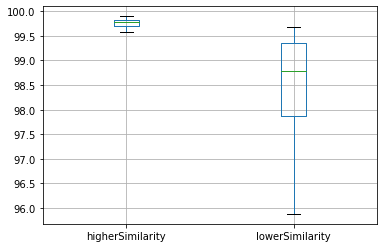

In [85]:
boxplot = togetherDF.boxplot(column = ['higherSimilarity', 'lowerSimilarity'])

From the boxplot, we can see that AWS identifies beryl with similarity scores higher than 99.5 overall and the range is tiny, while the similarity scores between beryl and amber is overall lower and the range is wider. In other words, AWS actually performs very well on identifying twins as it gives overall higher similarity scores for the correct person.

We can also tune the parameter of the function compare_faces by setting the SimilarityThreshold very high (i.e. 99.5), then we may be able to identify only one person in the photo as beryl.

In [86]:
response=client.compare_faces(SimilarityThreshold=99.5,
                                  SourceImage={'S3Object':{'Bucket':"350-rekog-project",'Name':"beryl1.jpeg"}},
                                  TargetImage={'S3Object':{'Bucket':"350-rekog-project",'Name':"together1.jpeg"}})
for faceMatch in response['FaceMatches']:
        position = faceMatch['Face']['BoundingBox']
        similarity = str(faceMatch['Similarity'])
        print('The face at ' +
               str(position['Left']) + ' ' +
               str(position['Top']) +
               ' matches with ' + similarity + '% confidence')
for faceNotMatch in response['UnmatchedFaces']:
    position = faceNotMatch['BoundingBox']
    confidence = str(faceNotMatch['Confidence'])
    print('The face at ' +
            str(position['Left']) + ' ' +
            str(position['Top']) +
            ' dose not match with ' + confidence + '% confidence')

The face at 0.5722591280937195 0.41717708110809326 matches with 99.89863586425781% confidence
The face at 0.3406957685947418 0.4428347945213318 dose not match with 99.99877166748047% confidence
The face at 0.1799880415201187 0.4139992594718933 dose not match with 99.99813079833984% confidence


However, we will miss 'true beryl' in some other cases because as we can see from the boxplots, the range of the similarity scores overlaps at some points. Thus we cannot find a 'best' similarity threshold that can distinguish amber from beryl without missing true beryl. Except from the ability to distinguish between twins, in the time of a pendamic, we would also like to discover whether masks will impact the recognition. And we would extend the data to people and their photos with glasses, masks and funny faces.

## Warmup and Setup on minor facial variations

In [88]:
import boto3

In [89]:
client = boto3.client('rekognition')

In [90]:
client.detect_labels(Image = {'S3Object':{'Bucket':'350project-image', 'Name':'a1.jpg'}})

{'Labels': [{'Name': 'Finger',
   'Confidence': 95.55704498291016,
   'Instances': [],
   'Parents': []},
  {'Name': 'Person',
   'Confidence': 91.80702209472656,
   'Instances': [{'BoundingBox': {'Width': 0.9945007562637329,
      'Height': 0.950671374797821,
      'Left': 0.0,
      'Top': 0.03495144471526146},
     'Confidence': 91.80702209472656}],
   'Parents': []},
  {'Name': 'Human',
   'Confidence': 91.80702209472656,
   'Instances': [],
   'Parents': []},
  {'Name': 'Apparel',
   'Confidence': 91.67005920410156,
   'Instances': [],
   'Parents': []},
  {'Name': 'Clothing',
   'Confidence': 91.67005920410156,
   'Instances': [],
   'Parents': []},
  {'Name': 'Face',
   'Confidence': 74.54094696044922,
   'Instances': [],
   'Parents': [{'Name': 'Person'}]},
  {'Name': 'Skin',
   'Confidence': 67.7409439086914,
   'Instances': [],
   'Parents': []},
  {'Name': 'Lip',
   'Confidence': 67.057373046875,
   'Instances': [],
   'Parents': []},
  {'Name': 'Mouth',
   'Confidence': 67.

## Compare faces when 1) original 2) glass-wearing 3) mask-covering 4) making funny faces

In [91]:
response = client.compare_faces(SimilarityThreshold=80,
                                  SourceImage={'S3Object':{'Bucket':"350project-image",'Name':"a1.jpg"}},
                                  TargetImage={'S3Object':{'Bucket':"350project-image",'Name':"a2.jpg"}})

In [92]:
for faceMatch in response['FaceMatches']:
        position = faceMatch['Face']['BoundingBox']
        similarity = str(faceMatch['Similarity'])
        print('The face at ' +
               str(position['Left']) + ' ' +
               str(position['Top']) +
               ' matches with ' + similarity + '% confidence')

The face at 0.26413869857788086 0.20291969180107117 matches with 99.99996185302734% confidence


In [93]:
for faceNotMatch in response['UnmatchedFaces']:
    position = faceNotMatch['BoundingBox']
    confidence = str(faceNotMatch['Confidence'])
    print('The face at ' +
            str(position['Left']) + ' ' +
            str(position['Top']) +
            ' dose not match with ' + confidence + '% confidence')

In [94]:
response

{'SourceImageFace': {'BoundingBox': {'Width': 0.5884437561035156,
   'Height': 0.633808970451355,
   'Left': 0.23545102775096893,
   'Top': 0.1488596349954605},
  'Confidence': 99.99200439453125},
 'FaceMatches': [{'Similarity': 99.99996185302734,
   'Face': {'BoundingBox': {'Width': 0.5546112060546875,
     'Height': 0.5667304992675781,
     'Left': 0.26413869857788086,
     'Top': 0.20291969180107117},
    'Confidence': 99.98955535888672,
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.42226552963256836,
      'Y': 0.4526117146015167},
     {'Type': 'eyeRight', 'X': 0.6778354048728943, 'Y': 0.4499421715736389},
     {'Type': 'mouthLeft', 'X': 0.4446648061275482, 'Y': 0.6642223000526428},
     {'Type': 'mouthRight', 'X': 0.6580995321273804, 'Y': 0.661880373954773},
     {'Type': 'nose', 'X': 0.5528274774551392, 'Y': 0.5827391743659973}],
    'Pose': {'Roll': -1.1150751113891602,
     'Yaw': 1.0638971328735352,
     'Pitch': -5.5680832862854},
    'Quality': {'Brightness': 91.873786

In [95]:
import numpy as np
import pandas as pd
import s3fs
fs = s3fs.S3FileSystem()

In [96]:
#Case for picture a group

In [97]:
def extract_similarity(photo):
    try:
        similarity = []
        comparison = client.compare_faces(
            SourceImage= {'S3Object':{'Bucket':"350project-image", 'Name':'a1.jpg'}},
            TargetImage = {'S3Object':{'Bucket':"350project-image",'Name':photo}})
        result = {}
        i = 0
        for faceMatch in comparison['FaceMatches']:
            position = faceMatch['Face']['BoundingBox']
            similarity = faceMatch['Similarity']
            result[i] = {}
            result[i]['similarity'] = similarity
            result[i]['position'] = position['Left']
            i+=1
        
    except Exception:
        similarity = np.nan
    return result

In [98]:
cl1 = "a2.jpg"
extract_similarity(cl1)

{0: {'similarity': 99.99996185302734, 'position': 0.26413869857788086}}

In [99]:
#Make a list of photoes

In [100]:
def extract_similarity(photo,source_photo):
    try:
        similarity = []
        comparison = client.compare_faces(
            SourceImage= {'S3Object':{'Bucket':"350project-image", 'Name':source_photo}},
            TargetImage = {'S3Object':{'Bucket':"350project-image",'Name':photo}})
        result = {}
        i = 0
        for faceMatch in comparison['FaceMatches']:
            position = faceMatch['Face']['BoundingBox']
            similarity = faceMatch['Similarity']
            result[i] = {}
            result[i]['similarity'] = similarity
            result[i]['position'] = position['Left']
            i+=1
        
    except Exception:
        similarity = np.nan
    return result

In [101]:
extract_similarity('c2.jpg','c1.jpg')

{0: {'similarity': 99.9999008178711, 'position': 0.2618192732334137}}

Secondly we want to identify if different facial expressions or accessories have a significant impact on the identification of individuals. We thus use five variables in this case, with one being the original picture – “Name” - and one being the control group – “null”. We hope to use the similarity between “name” and “null” as a benchmark to find out whether the differences (if any) found in the mean of the other groups are significant. 
Here the three groups we use to compare with are: 1) glass-wearing; 2) mask-covering; 3) making funny faces. Their similarity to the original picture is returned as the input in the following table:

In [102]:
names = ['Claire','Crystal','Gloria','BJT','dl','gql','hj','hzt',
         'lhr','lx','mino','whd','wjk','wyb','wyf','yy','yyqx',
         'zry','angelina','arriana','cate','emma','emmas','jenniferb',
         'jenniferl','jessica','julia','melissa','meryl',
        'ruby','scarlett','wendy']
image_dict = {'Claire':['a1.jpg','a2.jpg','a3.jpg','a4.jpg','a5.jpg'],
 'Crystal':['b1.jpg','b2.jpg','b3.jpg','b4.jpg','b5.jpg'],
 'Gloria':['c1.jpg', 'c2.jpg', 'c3.jpg', 'c4.jpg','c5.jpg'],
 'BJT':['bjt1.JPG','bjt2.JPG','bjt3.JPG','bjt4.JPG','bjt5.jpg'],
 'dl':['dl1.JPG','dl2.JPG','dl3.JPG','dl4.JPG','dl5.jpg'],
 'gql':['gql1.JPG','gql2.JPG','gql3.JPG','gql4.JPG','gql5.jpg'],
 'hj':['hj1.JPG','hj2.JPG','hj3.JPG','hj4.JPG','hk4.JPG'],
 'hzt':['hzt1.JPG','hzt2.JPG','hzt3.JPG','hzt4.JPG','hzt5.jpg'],
 'lhr':['lhr1.JPG','lhr2.JPG','lhr3.JPG','lhr4.JPG','lhr5.JPG'],
 'lx':['lx1.JPG','lx2.JPG','lx3.JPG','lx4.JPG','lx5.JPG'],
 'mino':['mino1.jpg','mino2.JPG','mino3.JPG','mino4.jpg','mino5.jpg'],
 'whd':['whd1.JPG','whd2.JPG','whd3.JPG','whd4.JPG','whd5.JPG'],
 'wjk':['wjk1.JPG','wjk2.JPG','wjk3.JPG','wjk4.JPG','wjk5.JPG'],
 'wyb':['wyb1.JPG','wyb2.JPG','wyb3.JPG','wyb4.JPG','wyb5.JPG'],
 'wyf':['wyf1.JPG','wyf2.JPG','wyf3.jpg','wyf4.JPG','wyf5.JPG'],
 'yy':['yy1.JPG','yy2.JPG','yy3.jpg','yy4.JPG','yy5.JPG'],
 'yyqx':['yyqx1.JPG','yyqx2.JPG','yyqx3.JPG','yyqx4.JPG','yyqx5.JPG'],
 'zry':['zry1.JPG','zry2.JPG','zry3.JPG','zry4.JPG','zry5.JPG'],
 'angelina':['angelina1.jpg','angelina2.jpg','angelina3.jpg','angelina4.jpg','angelina5.jpg'],
 'arriana':['arriana1.jpg','arriana2.jpg','arriana3.jpg','arriana4.jpg','arriana5.jpg'],
 'cate':['cate1.jpg','cate2.jpg','cate3.jpg','cate4.jpg','cate5.jpg'],
 'emma':['emma1.jpg','emma2.jpg','emma3.jpg','emma4.jpg','emma5.jpg'],
 'emmas':['emmas1.jpg','emmas2.jpg','emmas3.jpg','emmas4.jpg','emmas5.jpg'],
 'jenniferb':['jenniferb1.jpg','jenniferb2.jpg','jenniferb3.jpg','jenniferb4.png','jenniferb5.jpg'],
 'jenniferl':['jenniferl1.jpg','jenniferl2.jpg','jenniferl3.jpg','jenniferl4.jpg','jenniferl5.jpg'],
 'jessica':['jessica1.jpg','jessica2.jpg','jessica3.jpg','jessica4.jpg','jessica5.jpg'],
 'julia':['julia1.jpg','julia2.jpg','julia3.jpg','julia4.jpg','julia5.jpg'],
 'melissa':['melissa1.jpg','melissa2.jpg','melissa3.jpg','melissa4.jpg','melissa5.jpg'],
 'meryl':['meryl1.jpg','meryl2.jpg','meryl3.jpg','meryl4.jpg','meryl5.jpg'],
 'ruby':['ruby1.jpg','ruby2.jpg','ruby3.jpg','ruby4.jpg','ruby5.jpg'],
 'scarlett':['scarlett1.jpg','scarlett2.jpg','scarlett3.jpg','scarlett4.jpg','scarlett5.jpg'],
 'wendy':['wendy1.jpg','wendy2.jpg','wendy3.jpg','wendy4.jpg','wendy5.jpg'],
             }

In [103]:
df = pd.DataFrame({'Name': names})
glasses = []
mask = []
funnyFace = []
null = []
for name in names: 
    try:
        source_photo = image_dict[name][0]
    except:
        print(name, "cannot be read")
    try:
        result_glasses = extract_similarity(image_dict[name][1], source_photo)
        similarity_glasses = result_glasses[0]['similarity']
        glasses.append(similarity_glasses)
    except:
        glasses.append(np.nan)
    try:
        result_mask = extract_similarity(image_dict[name][2], source_photo)
        similarity_mask = result_mask[0]['similarity']
        mask.append(similarity_mask)
    except:
        mask.append(np.nan)
    try:
        result_funnyFace = extract_similarity(image_dict[name][3], source_photo)
        similarity_funnyFace = result_funnyFace[0]['similarity']
        funnyFace.append(similarity_funnyFace)
    except:
        funnyFace.append(np.nan)
    try:
        result_null = extract_similarity(image_dict[name][4], source_photo)
        similarity_null = result_null[0]['similarity']
        null.append(similarity_null)
    except:
        null.append(np.nan)

In [104]:
df['glasses'] = glasses
df['mask'] = mask
df['funnyFace'] = funnyFace
df['null'] = null
df

,Name,glasses,mask,funnyFace,null
0,Claire,99.999962,99.764030,99.998238,99.999550
1,Crystal,99.999977,99.325432,99.999756,99.999496
2,Gloria,99.999901,99.588600,99.879562,99.909981
3,BJT,99.978279,95.866455,99.648323,99.991486
4,dl,99.986786,92.788857,99.978821,NaN
5,gql,99.240044,99.709496,99.630646,99.990356
6,hj,99.994537,99.856712,99.819168,NaN
7,hzt,99.986603,99.222954,99.964043,99.997429
8,lhr,99.970398,99.539986,99.897995,99.832001
9,lx,99.873932,97.319206,99.973778,99.998901


From the dataframe, we can see that the column of 'mask' contains many nan values, which means AWS Rekognition fails to identify the person from the photo of the person wearing mask. Then, we use a boxplot to better visualize:

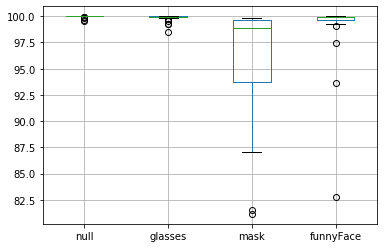

In [105]:
boxplot = df.boxplot(column = ['null','glasses', 'mask', 'funnyFace'])


The boxplot confirms our initial thought that each group has a different mean, especially the mask group. So we conduct a hypothesis testing:

    Null Hypothesis: There is no significant difference between the means of the variables. 
    Alternative Hypothesis: There is a significant difference between the means of the variables.
    Testing Method: One-way ANOVA Testing

In [106]:
from scipy.stats import f_oneway

In [107]:
F,p = f_oneway(df['null'][~np.isnan(df['null'])],df['glasses'][~np.isnan(df['glasses'])], df['mask'][~np.isnan(df['mask'])], df['funnyFace'][~np.isnan(df['funnyFace'])])

In [108]:
F

9.017194794507072

In [109]:
p

2.2639456311411546e-05

Result: The One-way ANOVA Testing shows an output F value of 9.017 and p-value=0.0000226. Using a 5% significance level, it shows that there is a 0.00226% risk of concluding that a difference exists when there is no actual difference. Thus, we reject the null hypothesis and conclude that not all population means are equal. 

But the ANOVA test only shows that it is likely that the four groups have a difference in mean, but it has not signified which groups is most likely to differ or which group differs by most. Therefore, we optimize our testing method by using T tests. 

    Null Hypothesis: There is no significant difference between the mean in the “glasses” group and the “null group. 
    Alternative Hypothesis: There is a significant difference between the mean in the “glasses” group and the “null” group.
    Testing Method: T-test

In [110]:
from scipy import stats

In [111]:
stats.ttest_ind(df['null'][~np.isnan(df['null'])],df['glasses'][~np.isnan(df['glasses'])], equal_var = False)

Ttest_indResult(statistic=1.702134484078732, pvalue=0.09696730057681158)

In [112]:
stats.ttest_ind(df['null'][~np.isnan(df['null'])],df['mask'][~np.isnan(df['mask'])], equal_var = False)

Ttest_indResult(statistic=3.3054977110315362, pvalue=0.003364403260063759)

In [113]:
stats.ttest_ind(df['null'][~np.isnan(df['null'])],df['funnyFace'][~np.isnan(df['funnyFace'])], equal_var = False)

Ttest_indResult(statistic=1.632198656154107, pvalue=0.11380903555402896)

By comparing the image of people wearing glasses, masks, and making funny faces with their daily pictures respectively, we could find that the p values are 0.097, 0.0034 and 0.114. Comparing with p=0.05, we can only reject the second group of which p=0.0034. We reject the null hypothesis that there is no difference between the mean of the group when people wear masks and when they are not. 

Combing our clusion with our observation from the dataframe, we finds that with the person wearing a mask in the photo, AWS Rekognition has higher probability to fail to regonize the person (by 'nan' fromt the dataframe), and for the part that AWS Rekognition match the faces with masks successfully, the mean similarity score is different from that of regular photos ('null') by T-test. This indicates that AWS Rekognition is less confident to identify people when they wear masks. 



## Conclusions

Because the mean similarity is significantly different between regular photos and photos with the person wearing mask, we conclude that Amazon Rekognition is less confident to identify faces when the individuals are wearing masks. 

We conclude that Amazon Rekognition still recognizes the individuals when they are wearing glasses and making funny faces. We also conclude that Amazon Rekognition is able to tell the twin sisters apart. 

Amazon Rekognition is relatively accurate in facial recognitions. The developers can look for ways that improve facial recognition when the individuals are wearing masks.